In [ ]:
!pip install jcopml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 4.6 MB/s 
  Created wheel for jcopml: filename=jcopml-1.1.15-py2.py3-none-any.whl size=32026 sha256=c4cced8eb2324d745866fc19e01aeaadf63fa64a81535d43a5fd942f39c088a7
  Stored in directory: /root/.cache/pip/wheels/43/7a/bb/396851d7ac5c4c9342ec8657593da1eee1bad1854e54d51d81
Successfully built jcopml


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import missingno as msno
warnings.simplefilter(action="ignore", category=FutureWarning)

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [ ]:
df = pd.read_csv('mushrooms.csv')
df

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,convex,smooth,brown,True,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,1,pendant,black,scattered,urban
1,True,convex,smooth,yellow,True,almond,free,close,broad,black,...,smooth,white,white,partial,white,1,pendant,brown,numerous,grasses
2,True,bell,smooth,white,True,anise,free,close,broad,brown,...,smooth,white,white,partial,white,1,pendant,brown,numerous,meadows
3,False,convex,scaly,white,True,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,1,pendant,black,scattered,urban
4,True,convex,smooth,gray,False,none,free,crowded,broad,black,...,smooth,white,white,partial,white,1,evanescent,brown,abundant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,True,knobbed,smooth,brown,False,none,attached,close,broad,yellow,...,smooth,NaN,NaN,partial,orange,1,pendant,buff,clustered,leaves
8120,True,convex,smooth,brown,False,none,attached,close,broad,yellow,...,smooth,NaN,NaN,partial,brown,1,pendant,buff,several,leaves
8121,True,flat,smooth,brown,False,none,attached,close,broad,brown,...,smooth,NaN,NaN,partial,orange,1,pendant,buff,clustered,leaves
8122,False,knobbed,scaly,brown,False,fishy,free,close,narrow,buff,...,silky,white,white,partial,white,1,evanescent,white,several,leaves


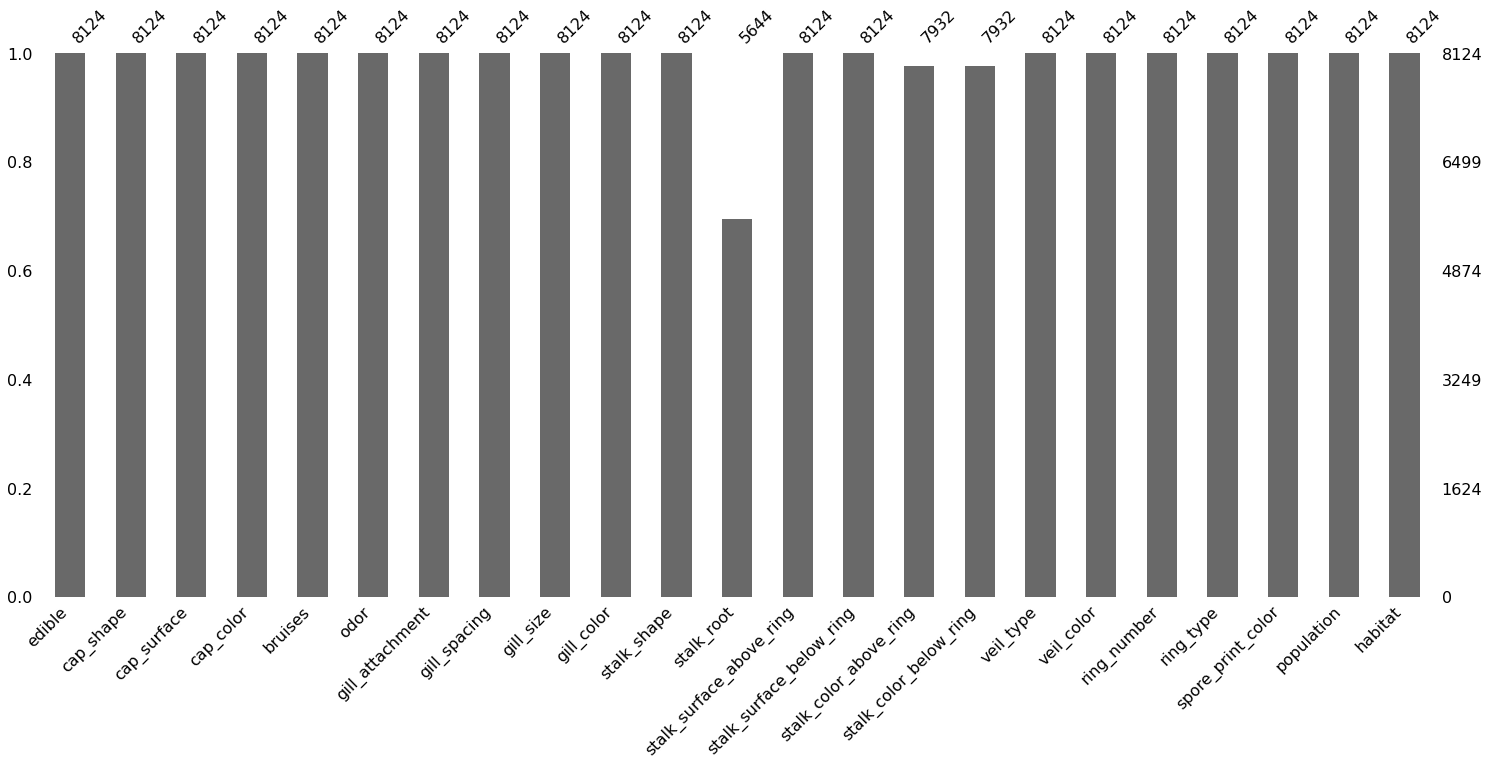

In [ ]:
msno.bar(df)

,missing_value,%
edible,0,0.00
cap_shape,0,0.00
cap_surface,0,0.00
cap_color,0,0.00
bruises,0,0.00
odor,0,0.00
gill_attachment,0,0.00
gill_spacing,0,0.00
gill_size,0,0.00
gill_color,0,0.00


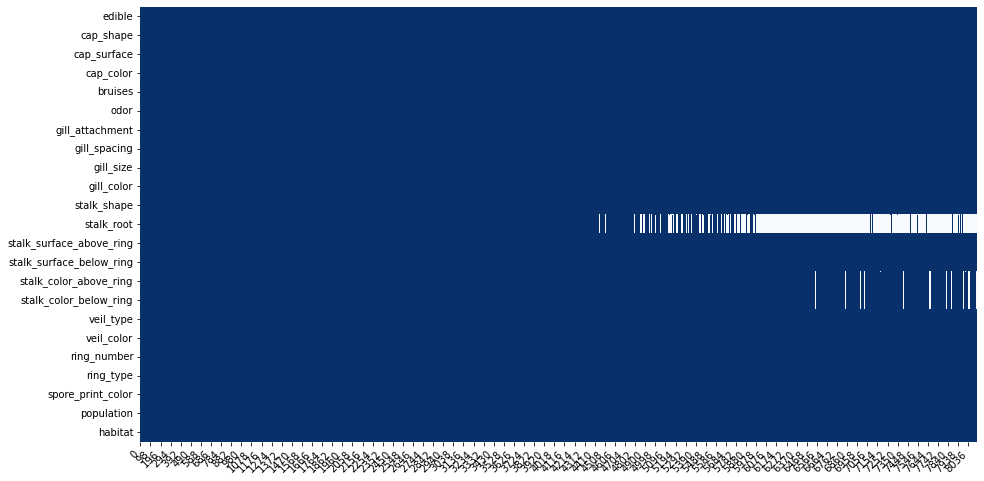

In [ ]:
plot_missing_value(df, return_df=True)

In [ ]:
df.dropna(inplace=True)

### Association Matriks

In [ ]:
from jcopml.plot import plot_association_matrix

In [ ]:
plot_association_matrix(df,"edible", categoric_col='auto')

ValueError: ignored

In [ ]:
df.veil_type.value_counts()

partial    5644
Name: veil_type, dtype: int64

In [ ]:
df.drop(columns='veil_type', inplace=True)

In [ ]:
plot_association_matrix(df,"edible", categoric_col='auto')

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

### Dataset Spliting

In [ ]:
from sklearn.model_selection import train_test_split

X = df[['odor', 'ring_type', 'spore_print_color']]
y = df.edible

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4515, 3), (1129, 3), (4515,), (1129,))

### Training

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [ ]:
preprocessor = ColumnTransformer([
                                  ('categoric', cat_pipe(encoder='onehot'), X_train.columns),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', LogisticRegression(solver='lbfgs', n_jobs=1, random_state=42))
])

model = GridSearchCV(pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.score(X_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'algo__C': 1.0, 'algo__fit_intercept': True}
0.997563676633444 0.995571302037201


### Evaluation

In [ ]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve, plot_pr_curve

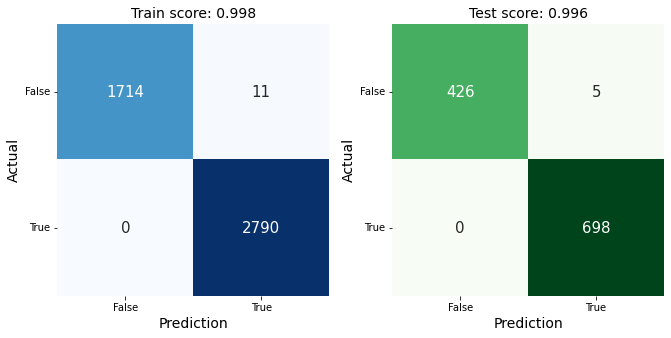

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       1.00      0.99      1.00      1725
        True       1.00      1.00      1.00      2790

    accuracy                           1.00      4515
   macro avg       1.00      1.00      1.00      4515
weighted avg       1.00      1.00      1.00      4515


Test report
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       431
        True       0.99      1.00      1.00       698

    accuracy                           1.00      1129
   macro avg       1.00      0.99      1.00      1129
weighted avg       1.00      1.00      1.00      1129



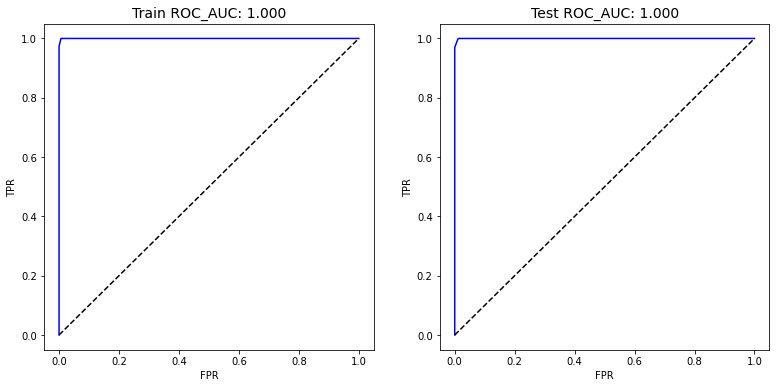

In [ ]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

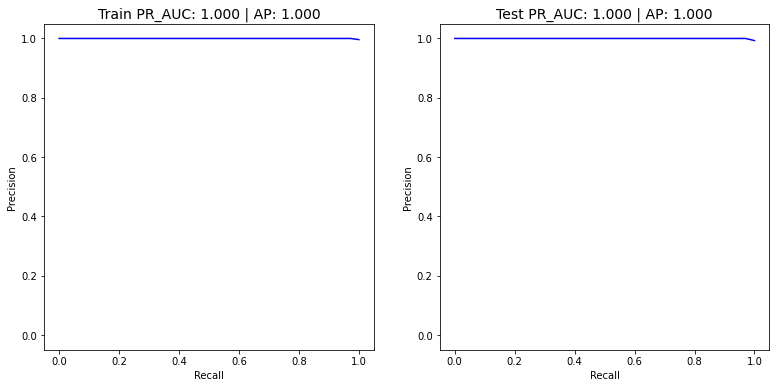

In [ ]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

### Feature Importance

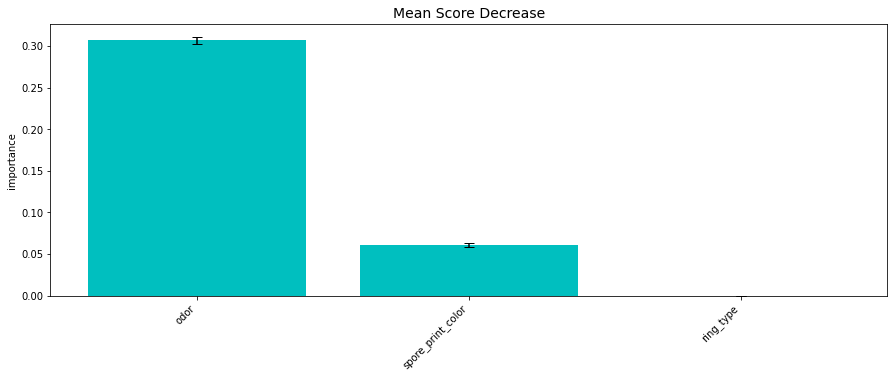

In [ ]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=5)

### Insight From Data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

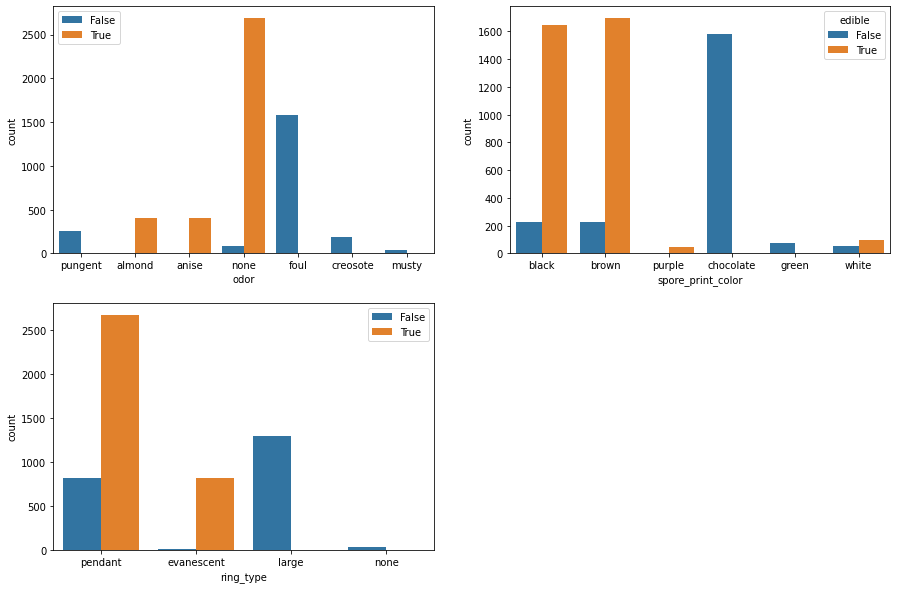

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
sns.countplot('odor', data=df, hue='edible',)
plt.legend(loc='upper left')
plt.subplot(222)
sns.countplot('spore_print_color', data=df, hue='edible')
plt.subplot(223)
sns.countplot('ring_type', data=df, hue='edible')
plt.legend(loc='upper right')

### Correlation Ratio

In [ ]:
from jcopml.plot import plot_correlation_ratio

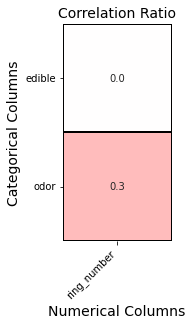

In [ ]:
plot_correlation_ratio(df, ['edible', 'odor'], ['ring_number'])